(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# Interpolation in Two-Dimensional Domains

## Introduction

Here we will extend the one-dimensional interpolation scheme studied previously to the more general case of a two-dimensional domain. From the geometric point of view we will also see that a **finite element** is just a canonical spatial domain described by nodal points and the corresponding set of interpolation (or **shape**) functions. Thus this will be the first formal definition of a finite element in the course. **After completing this notebook you should be able to:**

* Recognize the problem of interpolation in two-dimensional domains as the application of the known one-dimensional scheme.

* Formalize the concept of a finite element as a canonical interpolation space with prescribed interpolation functions.

* Propose interpolation schemes for general two-dimensional domains.

## Two-dimensional domain
Consider the two-dimensional square domain shown in the figure and where we want to approximate, via interpolation, a scalar (or vector) valued fuction $f=f(x,y)$. For that purpose the black-dots in the figure, represent nodal or sampling points where the function is assumed to be known. As discussed in the **Class Notes (Section 1.4)** the interpolating polynomial, in this case denoted by $p(x,y)$ is built like:

$$p(x,y) = H^Q(x,y)f^Q$$

where $Q = 1,...,N$ for a *N*-noded domain and where $H^Q(x,y)$ are the interpolation polynomials which in the context of the finite element method are called **Shape Funtions**.

To built the bi-dimensional interpolation functions $ H^Q(x,y)$ we actually perform an iterated one-dimensional interpolation as described next.

Let $x^A$ and $x^B$ denote the x-coordinates of points A and B for the square domain, shown in the figure below and assume we would like to find the value of the function at point A.

<center><img src="img/element.png" alt="Element" style="width:300px"></center>

Point A has an arbitrary y-coordinate but a constant $x = x^A$ x-coordinate, thus for an arbitrary point A along the 1-4 direction (see figure below) the interpolation scheme is still one-dimensional with only y-dependence as indicated by the label $f(y , x= A)$ in the figure. Using known one-dimensional Lagrange polynomials this y-dependence can be captured by:

$$f(x^A , y) = L^1(y)f^1 + L^4(y)f^4$$


<center><img src="img/inter1D.png" alt="1direction" style="width:300px"></center>

Proceeding similarly for an arbitrary point B along the 2-3 direction leads to:

$$f(x^B , y) = L^2(y)f^2 + L^3(y)f^3.$$

With $f^A$ and $f^B$ known the x-dependence can now be captured like:

$$f(x,y) = L^A(x) f(x^A,y) + L^B(x)f(x^B,y).$$

To arrive at the final 2D-shape functions we compute the polynomials $L^2(y)$, $L^3(y)$, $ L^A(x)$ and $ L^B(x)$ and replace them in the expressions above. In the case of an element of side 2.0 these functions take the form:

\begin{align*}
H^1(x,y) & = L^1(x)L^1(y) \equiv \frac14(1-x)(1-y)\\
H^2(x,y) & = L^2(x)L^1(y) \equiv \frac14(1+x)(1-y)\\
H^3(x,y) & = L^2(x)L^2(y) \equiv \frac14(1+x)(1+y)\\
H^4(x,y) & = L^1(x)L^2(y) \equiv \frac14(1-x)(1+y).
\end{align*}


Since along each line 1-4 or 2-3 one-dimensional interpolation is being used, the formulated element is termed a bi-linear element.

### A Canonical Finite Element

In the following subroutine we code the final form $H^Q(x,y)$ of the shape functions instead of directly computing the fundamental 1D-polynomials of the form $L^I(y)$ and computing the iterated interpolation. The subroutine, named here **sha4()** stores the functions in a matrix structure which depends on $x$ and $y$. Here we assume that the element is a perfect square of side $\mathcal l=2.0$ with nodal points at the corners thus allowing for linear interpolation along each face.

In [1]:
%matplotlib notebook        
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from scipy import interpolate
import math

In [2]:
def sha4(x,y):
    """
    Compute the shape functions for bi-linear
    square element of size 2.0.
    """
    sh=sym.zeros(4)
    sh[0] =(1.0/4.0)*(1 - x)*(1 - y)
    sh[1] =(1.0/4.0)*(1 + x)*(1 - y)
    sh[2] =(1.0/4.0)*(1 + x)*(1 + y)
    sh[3] =(1.0/4.0)*(1 - x)*(1 + y)
#
    return sh

This square-element is a **canonical** or reference element where it is easy to conduct the interpolation operation. In an actual finite element discretization the resulting quadrilateral elements are expected to be distorted with respect to this canonical element. In these cases interpolation is still conducted in the space of the canonical element and geometry and functions are nicely transformed using simple mathematics. However, those details will be discussed later. 

The shape functions stored in the subroutine correspond to:

$$H = \frac14\begin{bmatrix}(1-x)(1-y)&(1+x)(1-y)&(1+x)(1+y)&(1-x)(1+y)\end{bmatrix}$$

**Questions:**

**(i) Write the element shape functions if the sub-domain is now the same squared element but now it also includes, in addition to the corner nodes, midside nodes to complete a total of 8 nodal points.**

**(ii) Make a copy of the subroutine **sha4()** and modify it to compute the shape functions for an 8-noded element.**

In [3]:
x , y= sym.symbols('x y')
H = sha4(x , y)

## Interpolation over a square element.

In this step we consider a square element conformed by 4-nodal points located at the corners and where nodal values of a function are assumed to be known. We use these values together with the shape functions to derive an interpolating polynomial. The resulting polynomial is used next to generate approximated values of the function along a set of points conforming a grid used to visualize the solution. The grid of observation points is generated using the function **mgrid** from **numpy**.

Notice that the system of reference is placed at the center of the element thus $x\in\lbrack-1\;,\;1\rbrack$ and $y\in\lbrack-1\;,\;1\rbrack$. The 1D array **USOL[]** will store the value interpolated at each point of the grid.

To conduct the interpolation we will assume known nodal values of the function at a given point $(x , y)$ so we can obtain the interpolated value like:

$$u(x,y)\;=\;\left[H(x,y)\right]\left\{u\right\}$$

**(Add comments to clarify the relevant steps in the code below)**.

In [4]:
li=-1.0
ls= 1.1
dl= 0.1
npts=int((ls-li)/dl)
USOL = np.zeros((npts, npts, 1))
xx, yy = np.mgrid[li:ls:npts*1j, li:ls:npts*1j]

<IPython.core.display.Javascript object>


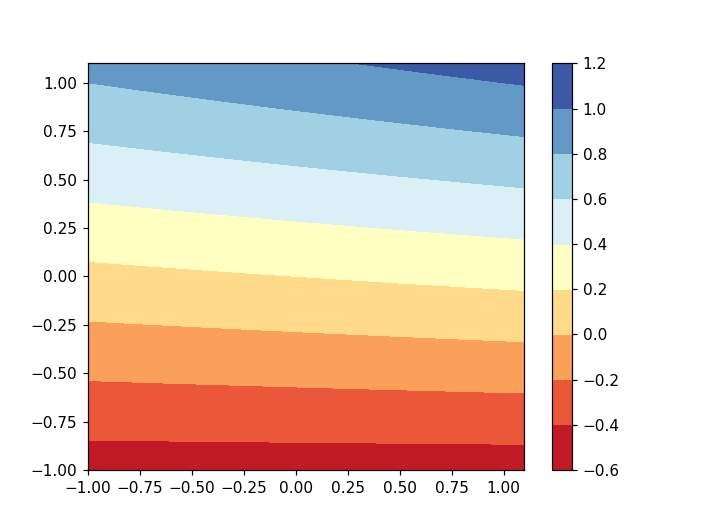

In [5]:
#
#Try different values of the function at the nodal points
#
u = sym.Matrix(4, 1, [-0.5 , -0.5 ,1.0 ,0.8])
#
for i in range(npts):
    for j in range(npts):
        NS =H.subs([(x, xx[i,j]), (y, yy[i,j])])
        up  = NS*u
        USOL[i, j, 0] = up[0]
plt.figure(1)
plt.contourf(xx , yy , USOL[:,:,0], cmap="RdYlBu")
plt.colorbar()

<IPython.core.display.Javascript object>


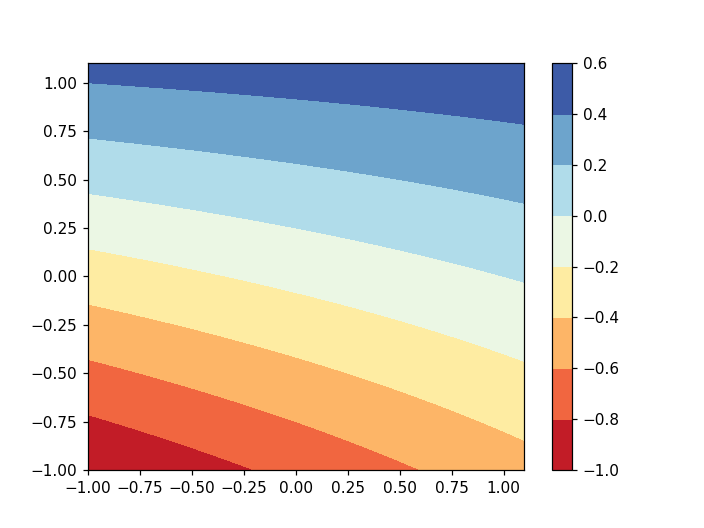

In [6]:
v = sym.Matrix(4, 1, [-1.0 , -0.5 ,+0.5 ,+0.4])
#
for i in range(npts):
    for j in range(npts):
        NS =H.subs([(x, xx[i,j]), (y, yy[i,j])])
        up  = NS*v
        USOL[i, j, 0] = up[0]
plt.figure(2)
plt.contourf(xx , yy , USOL[:,:,0], cmap="RdYlBu")
plt.colorbar()

Matrix([[1.11803398874989], [0.707106781186548], [1.11803398874989], [0.894427190999916]])


<IPython.core.display.Javascript object>


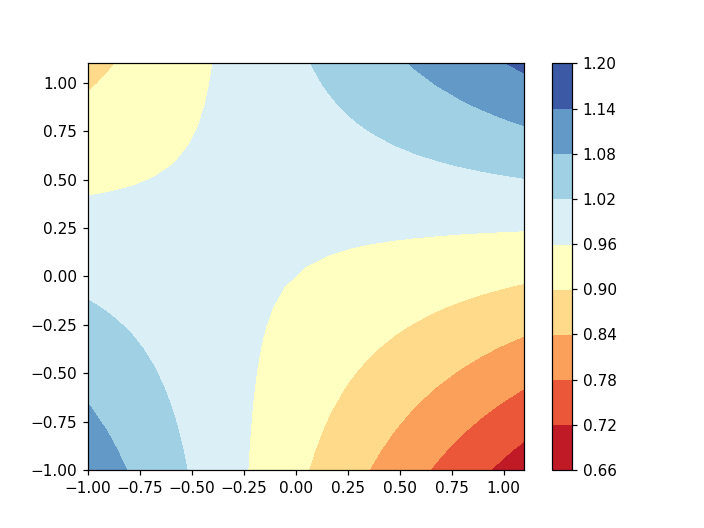

In [7]:
v_mag = sym.Matrix([math.sqrt(u[i]**2 + v[i]**2) for i in range(4)])
#for i in range(3):
#    v_mag[i] =math.sqrt(u[i]**2 + v[i]**2)
print(v_mag)
#
for i in range(npts):
    for j in range(npts):
        NS =H.subs([(x, xx[i,j]), (y, yy[i,j])])
        up  = NS*v_mag
        USOL[i, j, 0] = up[0]
plt.figure(3)
plt.contourf(xx , yy , USOL[:,:,0], cmap="RdYlBu")
plt.colorbar()

### Glossary of terms

**Canonical finite element:** Undistorted constant size sub-domain with fixed shape functions. In a practical case the elements differ in size and level of distortion, however all of them are geometrically transformed to the canonical element.

**Shape functions:** Interpolation functions formulated over a canonical element.

**Mesh:** A set of finite elements covering a given computational domain. A mesh is refined when the characteristic element size reduces generating a larger number of elements to cover the same compuattional domain.

### Class activity
**Problem 1**

Extend the 2D interpolation scheme discussed above to the case of a vector valued function in the context of linear elasticity. For that purpose:

* Assume that at each nodal point of the square domain the displacement vector with horizontal and vertical componentes denoted by $u$ and $v$ respectively is known.
* Using these nodal values compute the horizontal and vertical displacement components over the element.
* Using these same nodal values compute the strain field given by:

$$\varepsilon_{xx}=\frac12\left(\frac{\partial u}{\partial x}\right)$$

$$\varepsilon_{yy}=\frac12\left(\frac{\partial v}{\partial y}\right)$$

$$\gamma_{yy}=\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}\right)$$

* Store the shape function derivatives in a separate matrix $B$.

**Problem 2**

In a realistic finite element problem and due to geometric irregularities in the computational domain all the elements of the mesh would have different geometric paramters. These differences not only complicate the interpolation process but even create serious problems on coding a systematic approach. In practice every real (distorted) element is transformed to a canonical element in such a way that the interpolation process is conducted in the canonical space. The figure below shows the relation between these two spaces emphasizing the fact that there is a one to one connecion between a point in both spaces. The mathematical details of the transformation are provided in the **Class Notes.**

<center><img src="img/isopar.png" alt="1direction" style="width:400px"></center>

* Compute the transformation between the distorted and canonical element spaces required to conduct two-dimensional interpolation in a realistic case.

In [8]:
def sha4nat(r,s):
    """
    Compute the shape functions for bi-linear
    square element of size 2.0.
    """
    sh=sym.zeros(4)
    N=sym.zeros(2 , 8)
    sh[0] =(1.0/4.0)*(1 - r)*(1 - s)
    sh[1] =(1.0/4.0)*(1 + r)*(1 - s)
    sh[2] =(1.0/4.0)*(1 + r)*(1 + s)
    sh[3] =(1.0/4.0)*(1 - r)*(1 + s)
    
    N[0,0]=sh[0]
    N[0,2]=sh[1]
    N[0,4]=sh[2]
    N[0,6]=sh[3]
    
    N[1,1]=sh[0]
    N[1,3]=sh[1]
    N[1,5]=sh[2]
    N[1,7]=sh[3]
#
    return N

Let us define the nodal points coordinates

In [9]:
coord = sym.Matrix(8, 1, [0.0 , 0.0 , 1.0 , 0.0 , 1.0 , 1.0 , 0.0 , 1.0])

Now conduct the interpolation:

In [10]:
r=0.0
s=0.0
N = sha4nat(r,s)
X = N*coord
print(X)

Matrix([[0.500000000000000], [0.500000000000000]])


In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()